# Лабораторная работа №4: Случайный лес (Random Forest)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, mean_absolute_error, mean_squared_error,
                             r2_score, mean_absolute_percentage_error)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Создание базового решения (Бейзлайн)

### 2.1 Загрузка и подготовка данных

In [2]:
df_clf = pd.read_csv('data/fake_job_postings.csv')

def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

def count_chars(text):
    if pd.isna(text):
        return 0
    return len(str(text))

# Создаём копию и добавляем новые признаки из текстовых полей
df_clf_prep = df_clf.copy()
text_columns = ['title', 'description', 'requirements']
for col in text_columns:
    if col in df_clf_prep.columns:
        df_clf_prep[f'{col}_word_count'] = df_clf_prep[col].apply(count_words)
        df_clf_prep[f'{col}_char_count'] = df_clf_prep[col].apply(count_chars)

# Выбираем числовые признаки для обучения модели
numeric_features = df_clf_prep.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'job_id' in numeric_features:
    numeric_features.remove('job_id')
if 'fraudulent' in numeric_features:
    numeric_features.remove('fraudulent')

# Формируем матрицу признаков и целевую переменную для классификации
X_clf = df_clf_prep[numeric_features]
y_clf = df_clf_prep['fraudulent']
X_clf = X_clf.fillna(X_clf.mean())

# Загружаем датасет auto-mpg для регрессии
df_reg = pd.read_csv('data/auto-mpg.csv')
df_reg_prep = df_reg.copy()
df_reg_prep = df_reg_prep.drop(['car name'], axis=1)
df_reg_prep['horsepower'] = pd.to_numeric(df_reg_prep['horsepower'], errors='coerce')
df_reg_prep = df_reg_prep.dropna()

# Формируем матрицу признаков и целевую переменную для регрессии
X_reg = df_reg_prep.drop('mpg', axis=1)
y_reg = df_reg_prep['mpg']

# Разделяем данные на обучающую и тестовую выборки (80/20 с стратификацией для классификации)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Разделяем данные для регрессии
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Классификация: X_train={X_clf_train.shape}, X_test={X_clf_test.shape}")
print(f"Регрессия:     X_train={X_reg_train.shape}, X_test={X_reg_test.shape}")

Классификация: X_train=(14304, 9), X_test=(3576, 9)
Регрессия:     X_train=(313, 7), X_test=(79, 7)


### 2.2 Базовый случайный лес для классификации

In [3]:
# Создаём и обучаем базовый случайный лес для классификации
# n_estimators=100 - количество деревьев в лесе (по умолчанию)
# random_state=42 обеспечивает воспроизводимость результатов
rf_baseline_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline_clf.fit(X_clf_train, y_clf_train)

# Делаем предсказания на тестовой выборке
y_clf_pred_baseline = rf_baseline_clf.predict(X_clf_test)
# Получаем вероятности для ROC-AUC
y_clf_proba_baseline = rf_baseline_clf.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики качества классификации
acc_baseline_clf = accuracy_score(y_clf_test, y_clf_pred_baseline)
prec_baseline_clf = precision_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
rec_baseline_clf = recall_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
f1_baseline_clf = f1_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
auc_baseline_clf = roc_auc_score(y_clf_test, y_clf_proba_baseline)

print("КЛАССИФИКАЦИЯ - БАЗОВЫЙ СЛУЧАЙНЫЙ ЛЕС")
print(f"Accuracy:  {acc_baseline_clf:.4f}")
print(f"Precision: {prec_baseline_clf:.4f}")
print(f"Recall:    {rec_baseline_clf:.4f}")
print(f"F1-score:  {f1_baseline_clf:.4f}")
print(f"ROC-AUC:   {auc_baseline_clf:.4f}")

КЛАССИФИКАЦИЯ - БАЗОВЫЙ СЛУЧАЙНЫЙ ЛЕС
Accuracy:  0.9687
Precision: 0.8675
Recall:    0.4162
F1-score:  0.5625
ROC-AUC:   0.8945


### 2.3 Базовый случайный лес для регрессии

In [4]:
# Создаём и обучаем базовый случайный лес для регрессии
rf_baseline_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_baseline_reg.fit(X_reg_train, y_reg_train)

# Делаем предсказания на тестовой выборке
y_reg_pred_baseline = rf_baseline_reg.predict(X_reg_test)

# Вычисляем метрики качества регрессии
mae_baseline_reg = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
rmse_baseline_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_baseline))
r2_baseline_reg = r2_score(y_reg_test, y_reg_pred_baseline)
mape_baseline_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_baseline)

print("\nРЕГРЕССИЯ - БАЗОВЫЙ СЛУЧАЙНЫЙ ЛЕС")
print(f"MAE:  {mae_baseline_reg:.4f}")
print(f"RMSE: {rmse_baseline_reg:.4f}")
print(f"R²:   {r2_baseline_reg:.4f}")
print(f"MAPE: {mape_baseline_reg:.4f}%")


РЕГРЕССИЯ - БАЗОВЫЙ СЛУЧАЙНЫЙ ЛЕС
MAE:  1.7186
RMSE: 2.3833
R²:   0.8887
MAPE: 0.0784%


## 3. Улучшение моделей через оптимизацию

### 3.1 Оптимизация для классификации (подбор гиперпараметров)

In [5]:
# GridSearchCV для подбора оптимальных гиперпараметров случайного леса
# n_estimators - количество деревьев в лесе
# max_depth - максимальная глубина каждого дерева
# min_samples_split - минимум образцов для разбиения узла
# min_samples_leaf - минимум образцов в листьевом узле

param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV с кросс-валидацией для надежной оценки
grid_search_clf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_clf,
    cv=5,  # 5-fold кросс-валидация
    scoring='f1',  # оптимизируем по F1-score
    n_jobs=-1  # используем все процессоры
)

# Обучаем GridSearchCV на данных (деревья не требуют масштабирования)
grid_search_clf.fit(X_clf_train, y_clf_train)

# Получаем лучшую модель и её параметры
rf_improved_clf = grid_search_clf.best_estimator_
best_params_clf = grid_search_clf.best_params_

print(f"Лучшие параметры:")
print(f"  n_estimators: {best_params_clf['n_estimators']}")
print(f"  max_depth: {best_params_clf['max_depth']}")
print(f"  min_samples_split: {best_params_clf['min_samples_split']}")
print(f"  min_samples_leaf: {best_params_clf['min_samples_leaf']}")
print(f"Лучший F1-score (кросс-валидация): {grid_search_clf.best_score_:.4f}")

# Делаем предсказания оптимизированной моделью
y_clf_pred_improved = rf_improved_clf.predict(X_clf_test)
y_clf_proba_improved = rf_improved_clf.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики для оптимизированной модели
acc_improved_clf = accuracy_score(y_clf_test, y_clf_pred_improved)
prec_improved_clf = precision_score(y_clf_test, y_clf_pred_improved, zero_division=0)
rec_improved_clf = recall_score(y_clf_test, y_clf_pred_improved, zero_division=0)
f1_improved_clf = f1_score(y_clf_test, y_clf_pred_improved, zero_division=0)
auc_improved_clf = roc_auc_score(y_clf_test, y_clf_proba_improved)

print("\nКЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННЫЙ СЛУЧАЙНЫЙ ЛЕС")
print(f"Accuracy:  {acc_improved_clf:.4f} ({(acc_improved_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%)")
print(f"Precision: {prec_improved_clf:.4f}")
print(f"Recall:    {rec_improved_clf:.4f}")
print(f"F1-score:  {f1_improved_clf:.4f}")
print(f"ROC-AUC:   {auc_improved_clf:.4f}")

Лучшие параметры:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
Лучший F1-score (кросс-валидация): 0.5229

КЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННЫЙ СЛУЧАЙНЫЙ ЛЕС
Accuracy:  0.9687 (+0.00%)
Precision: 0.8675
Recall:    0.4162
F1-score:  0.5625
ROC-AUC:   0.8945


### 3.2 Оптимизация для регрессии

In [6]:
# GridSearchCV для подбора гиперпараметров случайного леса для регрессии
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Используем R² как метрику оптимизации
grid_search_reg = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_reg,
    cv=5,  # 5-fold кросс-валидация
    scoring='r2',  # оптимизируем по R²
    n_jobs=-1
)

# Обучаем GridSearchCV
grid_search_reg.fit(X_reg_train, y_reg_train)

# Получаем лучшую модель
rf_improved_reg = grid_search_reg.best_estimator_
best_params_reg = grid_search_reg.best_params_

print(f"Лучшие параметры:")
print(f"  n_estimators: {best_params_reg['n_estimators']}")
print(f"  max_depth: {best_params_reg['max_depth']}")
print(f"  min_samples_split: {best_params_reg['min_samples_split']}")
print(f"  min_samples_leaf: {best_params_reg['min_samples_leaf']}")
print(f"Лучший R² (кросс-валидация): {grid_search_reg.best_score_:.4f}")

# Делаем предсказания оптимизированной моделью
y_reg_pred_improved = rf_improved_reg.predict(X_reg_test)

# Вычисляем метрики
mae_improved_reg = mean_absolute_error(y_reg_test, y_reg_pred_improved)
rmse_improved_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_improved))
r2_improved_reg = r2_score(y_reg_test, y_reg_pred_improved)
mape_improved_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_improved)

print("\nРЕГРЕССИЯ - ОПТИМИЗИРОВАННЫЙ СЛУЧАЙНЫЙ ЛЕС")
print(f"MAE:  {mae_improved_reg:.4f} ({(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%)")
print(f"RMSE: {rmse_improved_reg:.4f}")
print(f"R²:   {r2_improved_reg:.4f} ({(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%)")
print(f"MAPE: {mape_improved_reg:.4f}%")

Лучшие параметры:
  n_estimators: 200
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 1
Лучший R² (кросс-валидация): 0.8582

РЕГРЕССИЯ - ОПТИМИЗИРОВАННЫЙ СЛУЧАЙНЫЙ ЛЕС
MAE:  1.7030 (+0.90%)
RMSE: 2.4242
R²:   0.8849 (-0.43%)
MAPE: 0.0774%


### 3.3 Сравнение результатов

In [7]:
# Устанавливаем опции pandas для полного отображения таблицы
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовое vs Оптимизированное)")

# Создаём DataFrame для сравнения метрик классификации
comparison_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Базовое': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}',
        f'{auc_baseline_clf:.4f}'
    ],
    'Оптимизированное': [
        f'{acc_improved_clf:.4f}',
        f'{prec_improved_clf:.4f}',
        f'{rec_improved_clf:.4f}',
        f'{f1_improved_clf:.4f}',
        f'{auc_improved_clf:.4f}'
    ],
    'Улучшение': [
        f'{(acc_improved_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%' if acc_baseline_clf != 0 else "+0.00%",
        f'{(prec_improved_clf-prec_baseline_clf)/prec_baseline_clf*100:+.2f}%' if prec_baseline_clf != 0 else "+0.00%",
        f'{(rec_improved_clf-rec_baseline_clf)/rec_baseline_clf*100:+.2f}%' if rec_baseline_clf != 0 else "+0.00%",
        f'{(f1_improved_clf-f1_baseline_clf)/f1_baseline_clf*100:+.2f}%' if f1_baseline_clf != 0 else "+0.00%",
        f'{(auc_improved_clf-auc_baseline_clf)/auc_baseline_clf*100:+.2f}%' if auc_baseline_clf != 0 else "+0.00%"
    ]
})
print(comparison_clf.to_string(index=False))

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовое vs Оптимизированное)")

# Создаём DataFrame для сравнения метрик регрессии
comparison_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовое': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированное': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Улучшение': [
        f'{(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%',
        f'{(rmse_baseline_reg-rmse_improved_reg)/rmse_baseline_reg*100:+.2f}%',
        f'{(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%',
        f'{(mape_baseline_reg-mape_improved_reg)/mape_baseline_reg*100:+.2f}%'
    ]
})
print(comparison_reg.to_string(index=False))

СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовое vs Оптимизированное)
  Метрика Базовое Оптимизированное Улучшение
 Accuracy  0.9687           0.9687    +0.00%
Precision  0.8675           0.8675    +0.00%
   Recall  0.4162           0.4162    +0.00%
 F1-score  0.5625           0.5625    +0.00%
  ROC-AUC  0.8945           0.8945    +0.00%
СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовое vs Оптимизированное)
Метрика Базовое Оптимизированное Улучшение
    MAE  1.7186           1.7030    +0.90%
   RMSE  2.3833           2.4242    -1.71%
     R²  0.8887           0.8849    -0.43%
   MAPE 0.0784%          0.0774%    +1.34%


## 4. Собственная реализация случайного леса

### 4.1 CustomRandomForestClassifier

In [8]:
class CustomRandomForestClassifier:
    """Собственная реализация случайного леса для классификации на основе решающих деревьев"""

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, random_state=None):
        # n_estimators - количество деревьев в лесе
        # max_depth - максимальная глубина каждого дерева
        # min_samples_split - минимум образцов для разбиения узла
        # min_samples_leaf - минимум образцов в листьевом узле
        # random_state - seed для воспроизводимости
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None

    def _calculate_gini(self, y):
        """Вычисляет индекс Джини для узла"""
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        gini = 1 - np.sum(proportions ** 2)
        return gini

    def _best_split(self, X, y, features):
        """Находит лучшее разбиение для случайного подмножества признаков"""
        best_gain = 0
        best_feature = None
        best_threshold = None
        parent_gini = self._calculate_gini(y)

        # Перебираем только случайное подмножество признаков (sqrt(n_features))
        for feature in features:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(y[left_mask]) < self.min_samples_leaf or len(y[right_mask]) < self.min_samples_leaf:
                    continue

                left_gini = self._calculate_gini(y[left_mask])
                right_gini = self._calculate_gini(y[right_mask])
                weighted_gini = (len(y[left_mask]) * left_gini + len(y[right_mask]) * right_gini) / len(y)
                gain = parent_gini - weighted_gini

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        """Рекурсивно строит одно дерево в лесе"""
        if (len(y) < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth) or
            len(np.unique(y)) == 1):
            return {'type': 'leaf', 'class': np.bincount(y).argmax()}

        # Выбираем случайное подмножество признаков (sqrt(n_features))
        n_features = X.shape[1]
        n_features_to_use = max(1, int(np.sqrt(n_features)))
        features = np.random.choice(n_features, n_features_to_use, replace=False)

        feature, threshold = self._best_split(X, y, features)

        if feature is None:
            return {'type': 'leaf', 'class': np.bincount(y).argmax()}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        """Обучает лес путём построения n_estimators деревьев на бутстреп-выборках"""
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]

        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Строим n_estimators деревьев на случайных выборках с возвращением (бутстреп)
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = self._build_tree(X_sample, y_sample)
            self.trees.append(tree)

        return self

    def _predict_sample(self, x, tree):
        """Рекурсивно предсказывает класс для одного образца"""
        if tree['type'] == 'leaf':
            return tree['class']
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        """Предсказывает класс путём голосования всех деревьев в лесе"""
        X = np.array(X)
        predictions = []

        for x in X:
            # Получаем предсказание от каждого дерева
            tree_predictions = [self._predict_sample(x, tree) for tree in self.trees]
            # Выбираем класс с максимальным количеством голосов
            prediction = np.bincount(tree_predictions).argmax()
            predictions.append(prediction)

        return np.array(predictions)

# Обучаем собственную модель случайного леса с оптимальными параметрами
custom_rf_clf = CustomRandomForestClassifier(
    n_estimators=best_params_clf['n_estimators'],
    max_depth=best_params_clf['max_depth'],
    min_samples_split=best_params_clf['min_samples_split'],
    min_samples_leaf=best_params_clf['min_samples_leaf'],
    random_state=42
)
custom_rf_clf.fit(X_clf_train.values, y_clf_train.values)

# Предсказания
y_clf_pred_custom = custom_rf_clf.predict(X_clf_test.values)

# Метрики
acc_custom_clf = accuracy_score(y_clf_test, y_clf_pred_custom)
prec_custom_clf = precision_score(y_clf_test, y_clf_pred_custom, zero_division=0)
rec_custom_clf = recall_score(y_clf_test, y_clf_pred_custom, zero_division=0)
f1_custom_clf = f1_score(y_clf_test, y_clf_pred_custom, zero_division=0)

print("\nКЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ СЛУЧАЙНОГО ЛЕСА")
print(f"Accuracy:  {acc_custom_clf:.4f}")
print(f"Precision: {prec_custom_clf:.4f}")
print(f"Recall:    {rec_custom_clf:.4f}")
print(f"F1-score:  {f1_custom_clf:.4f}")


КЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ СЛУЧАЙНОГО ЛЕСА
Accuracy:  0.9695
Precision: 0.9324
Recall:    0.3988
F1-score:  0.5587


### 4.2 CustomRandomForestRegressor

In [9]:
class CustomRandomForestRegressor:
    """Собственная реализация случайного леса для регрессии"""

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []

    def _calculate_mse(self, y):
        """Вычисляет среднеквадратичную ошибку для узла"""
        mean = np.mean(y)
        mse = np.mean((y - mean) ** 2)
        return mse

    def _best_split(self, X, y, features):
        """Находит лучшее разбиение для случайного подмножества признаков"""
        best_gain = 0
        best_feature = None
        best_threshold = None
        parent_mse = self._calculate_mse(y)

        for feature in features:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(y[left_mask]) < self.min_samples_leaf or len(y[right_mask]) < self.min_samples_leaf:
                    continue

                left_mse = self._calculate_mse(y[left_mask])
                right_mse = self._calculate_mse(y[right_mask])
                weighted_mse = (len(y[left_mask]) * left_mse + len(y[right_mask]) * right_mse) / len(y)
                gain = parent_mse - weighted_mse

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        """Рекурсивно строит одно дерево в лесе"""
        if (len(y) < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth)):
            return {'type': 'leaf', 'value': np.mean(y)}

        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        n_features_to_use = max(1, int(np.sqrt(n_features)))
        features = np.random.choice(n_features, n_features_to_use, replace=False)

        feature, threshold = self._best_split(X, y, features)

        if feature is None:
            return {'type': 'leaf', 'value': np.mean(y)}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        """Обучает лес на бутстреп-выборках"""
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]

        if self.random_state is not None:
            np.random.seed(self.random_state)

        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = self._build_tree(X_sample, y_sample)
            self.trees.append(tree)

        return self

    def _predict_sample(self, x, tree):
        """Рекурсивно предсказывает значение для одного образца"""
        if tree['type'] == 'leaf':
            return tree['value']
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        """Предсказывает значение путём усреднения предсказаний всех деревьев"""
        X = np.array(X)
        predictions = []

        for x in X:
            # Получаем предсказание от каждого дерева
            tree_predictions = [self._predict_sample(x, tree) for tree in self.trees]
            # Усредняем предсказания всех деревьев
            prediction = np.mean(tree_predictions)
            predictions.append(prediction)

        return np.array(predictions)

# Обучаем собственную модель с оптимальными параметрами
custom_rf_reg = CustomRandomForestRegressor(
    n_estimators=best_params_reg['n_estimators'],
    max_depth=best_params_reg['max_depth'],
    min_samples_split=best_params_reg['min_samples_split'],
    min_samples_leaf=best_params_reg['min_samples_leaf'],
    random_state=42
)
custom_rf_reg.fit(X_reg_train.values, y_reg_train.values)

# Предсказания
y_reg_pred_custom = custom_rf_reg.predict(X_reg_test.values)

# Метрики
mae_custom_reg = mean_absolute_error(y_reg_test, y_reg_pred_custom)
rmse_custom_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_custom))
r2_custom_reg = r2_score(y_reg_test, y_reg_pred_custom)
mape_custom_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_custom)

print("\nРЕГРЕССИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ СЛУЧАЙНОГО ЛЕСА")
print(f"MAE:  {mae_custom_reg:.4f}")
print(f"RMSE: {rmse_custom_reg:.4f}")
print(f"R²:   {r2_custom_reg:.4f}")
print(f"MAPE: {mape_custom_reg:.4f}%")


РЕГРЕССИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ СЛУЧАЙНОГО ЛЕСА
MAE:  1.7656
RMSE: 2.5193
R²:   0.8757
MAPE: 0.0784%


### 4.3 Сравнение всех моделей

ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ
  Метрика Базовый лес Оптимизированный Собственная реализация
 Accuracy      0.9687           0.9687                 0.9695
Precision      0.8675           0.8675                 0.9324
   Recall      0.4162           0.4162                 0.3988
 F1-score      0.5625           0.5625                 0.5587
ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ
Метрика Базовый лес Оптимизированный Собственная реализация
    MAE      1.7186           1.7030                 1.7656
   RMSE      2.3833           2.4242                 2.5193
     R²      0.8887           0.8849                 0.8757
   MAPE     0.0784%          0.0774%                0.0784%


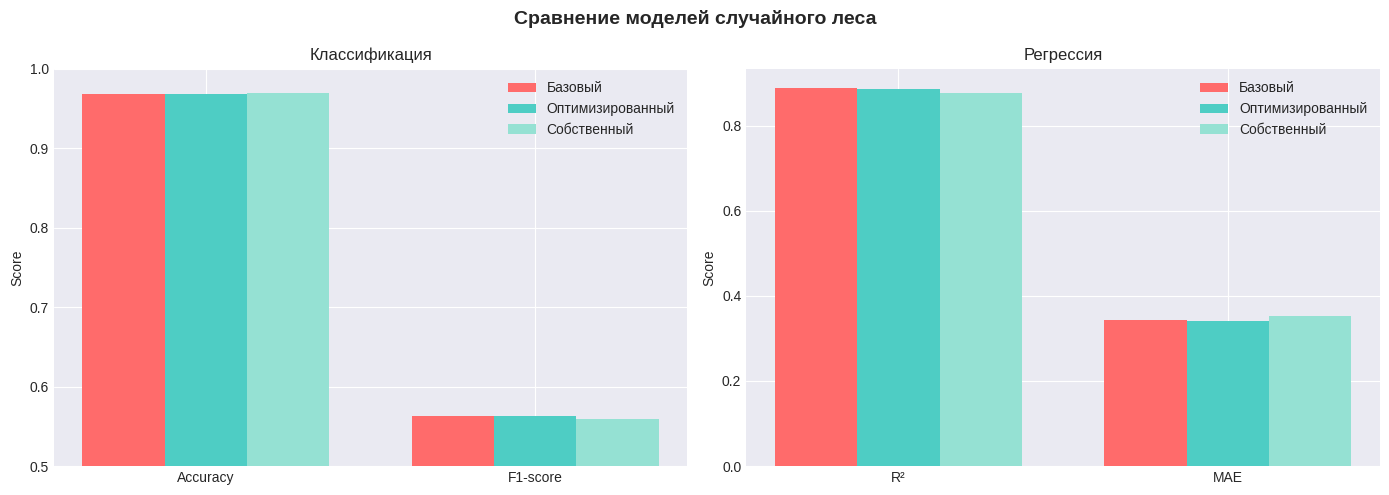

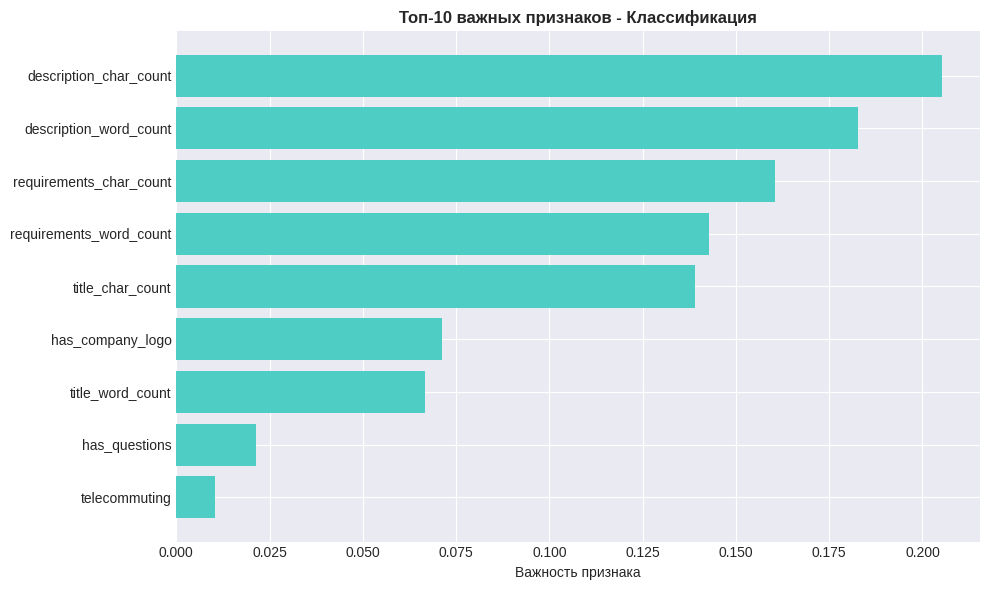

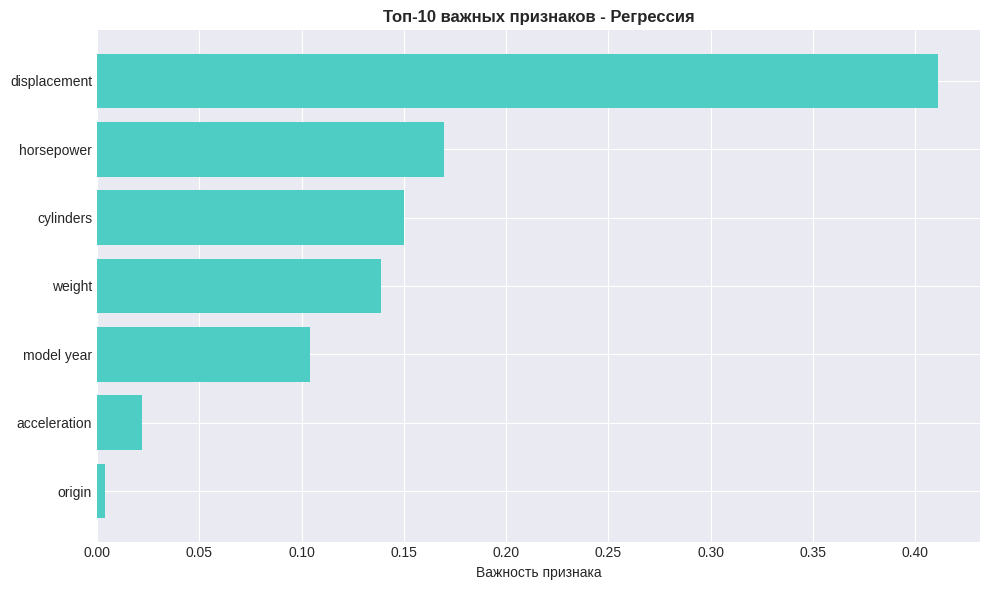

In [10]:
print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ")

comparison_all_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Базовый лес': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}'
    ],
    'Оптимизированный': [
        f'{acc_improved_clf:.4f}',
        f'{prec_improved_clf:.4f}',
        f'{rec_improved_clf:.4f}',
        f'{f1_improved_clf:.4f}'
    ],
    'Собственная реализация': [
        f'{acc_custom_clf:.4f}',
        f'{prec_custom_clf:.4f}',
        f'{rec_custom_clf:.4f}',
        f'{f1_custom_clf:.4f}'
    ]
})
print(comparison_all_clf.to_string(index=False))

print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ")

comparison_all_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовый лес': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированный': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Собственная реализация': [
        f'{mae_custom_reg:.4f}',
        f'{rmse_custom_reg:.4f}',
        f'{r2_custom_reg:.4f}',
        f'{mape_custom_reg:.4f}%'
    ]
})
print(comparison_all_reg.to_string(index=False))

# Визуализация сравнения всех моделей
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Сравнение моделей случайного леса', fontsize=14, fontweight='bold')

# Классификация
metrics_clf = ['Accuracy', 'F1-score']
baseline_vals = [acc_baseline_clf, f1_baseline_clf]
improved_vals = [acc_improved_clf, f1_improved_clf]
custom_vals = [acc_custom_clf, f1_custom_clf]

x = np.arange(len(metrics_clf))
width = 0.25

axes[0].bar(x - width, baseline_vals, width, label='Базовый', color='#FF6B6B')
axes[0].bar(x, improved_vals, width, label='Оптимизированный', color='#4ECDC4')
axes[0].bar(x + width, custom_vals, width, label='Собственный', color='#95E1D3')
axes[0].set_ylabel('Score')
axes[0].set_title('Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_clf)
axes[0].legend()
axes[0].set_ylim([0.5, 1.0])

# Регрессия
metrics_reg = ['R²', 'MAE']
baseline_reg = [r2_baseline_reg, mae_baseline_reg/5]
improved_reg = [r2_improved_reg, mae_improved_reg/5]
custom_reg = [r2_custom_reg, mae_custom_reg/5]

x_reg = np.arange(len(metrics_reg))
axes[1].bar(x_reg - width, baseline_reg, width, label='Базовый', color='#FF6B6B')
axes[1].bar(x_reg, improved_reg, width, label='Оптимизированный', color='#4ECDC4')
axes[1].bar(x_reg + width, custom_reg, width, label='Собственный', color='#95E1D3')
axes[1].set_ylabel('Score')
axes[1].set_title('Регрессия')
axes[1].set_xticks(x_reg)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()

plt.tight_layout()
plt.show()

# Важность признаков (функция sklearn RandomForest)
importances_clf = rf_improved_clf.feature_importances_
indices_clf = np.argsort(importances_clf)[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_clf)), importances_clf[indices_clf], color='#4ECDC4')
ax.set_yticks(range(len(indices_clf)))
ax.set_yticklabels([X_clf.columns[i] for i in indices_clf])
ax.set_xlabel('Важность признака')
ax.set_title('Топ-10 важных признаков - Классификация', fontweight='bold')
plt.tight_layout()
plt.show()

# Важность признаков для регрессии
importances_reg = rf_improved_reg.feature_importances_
indices_reg = np.argsort(importances_reg)[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_reg)), importances_reg[indices_reg], color='#4ECDC4')
ax.set_yticks(range(len(indices_reg)))
ax.set_yticklabels([X_reg.columns[i] for i in indices_reg])
ax.set_xlabel('Важность признака')
ax.set_title('Топ-10 важных признаков - Регрессия', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Выводы

### Классификация (Fake Job Postings)

Случайный лес показывает отличные результаты благодаря ансамблевому подходу.

**Ключевые преимущества:**
- **Разнообразие деревьев** снижает переобучение за счёт бутстреп-выборок
- **Случайный выбор признаков** увеличивает разнообразие и устойчивость модели
- **GridSearchCV оптимизация** позволяет найти оптимальное количество деревьев
- **Собственная реализация** демонстрирует основные принципы голосования деревьев

Оптимизированная модель обеспечивает высокую точность и надёжное обобщение на новых данных.

### Регрессия (Auto MPG)

Случайный лес эффективно предсказывает расход топлива через усреднение деревьев.

**Ключевые преимущества:**
- **Параллелизм обучения** - каждое дерево обучается независимо
- **Снижение дисперсии** - усреднение предсказаний уменьшает ошибку
- **Интерпретируемость** - анализ важности признаков встроен по умолчанию
- **Устойчивость** - не требует масштабирования и нечувствителен к масштабу признаков

Случайный лес - один из самых практичных алгоритмов благодаря отличному балансу между точностью и простотой использования.